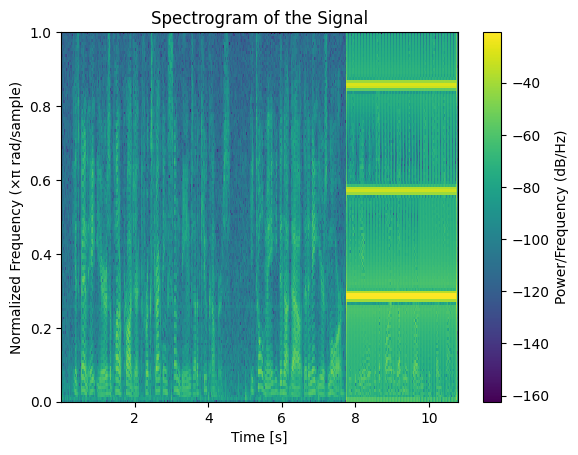

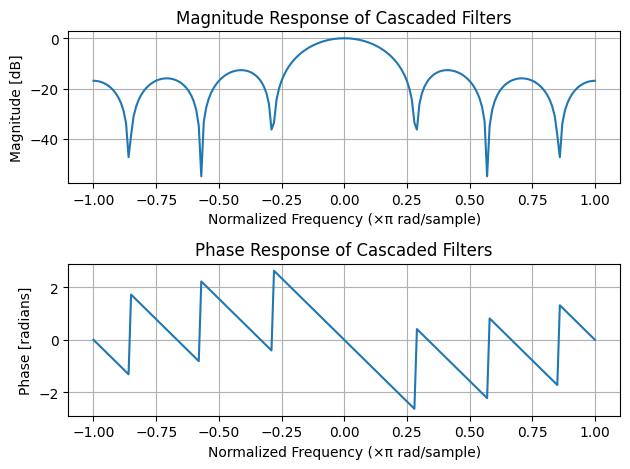

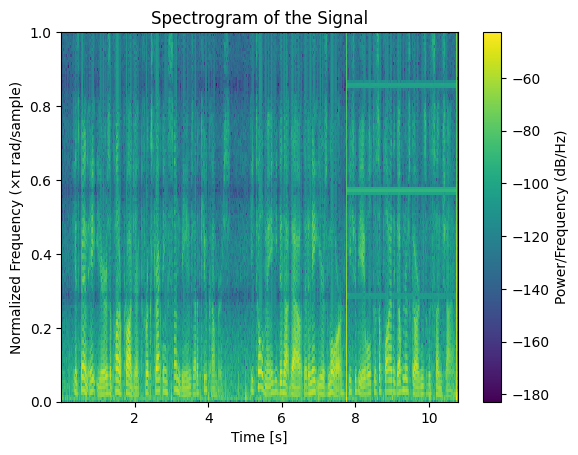

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram, lfilter, convolve, freqz
import sounddevice as sd

xx, fs = sf.read('SunShineSquare.wav')

if (len(xx.shape) > 1):
    xx = xx[:, 0]

xx = xx.astype(float)   

sd.play(xx,fs)
sd.wait()

def plot_spectrogram(signal, fs):
    """
    Plots the spectrogram of a given signal with normalized frequency (in terms of π radians/sample).

    Parameters:
    -----------
    signal : array-like
        The input audio signal to be analyzed. This can be a 1D numpy array representing the signal over time.
    
    fs : int
        The sampling frequency of the signal (in Hz). This is needed to compute the spectrogram and normalize the frequencies.
    """
    # Parameters to obtain a better spectrogram
    nfft = 256  # FFT size
    window = np.hamming(nfft)  # Hamming window
    noverlap = nfft // 2  # 50% overlap, same as MATLAB's default
    
    # Calculate the spectrogram
    frequencies, times, Sxx = spectrogram(signal, fs, window=window, nfft=nfft, noverlap=noverlap)

    # Normalize frequency in terms of pi radians/sample
    normalized_frequencies = frequencies / (fs / 2)  # Normalize by Nyquist frequency
    
    # Plot the spectrogram with normalized frequency
    plt.figure()
    plt.pcolormesh(times, normalized_frequencies, 10 * np.log10(Sxx))
    plt.ylabel('Normalized Frequency (×π rad/sample)')
    plt.xlabel('Time [s]')
    plt.title('Spectrogram of the Signal')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim([0, 1])  # Since normalized frequency is from 0 to 1
    plt.show()

plot_spectrogram(xx,fs)
# Define the frequencies to notch 
w1 = 0.2857
w2 = 0.5709
w3 = 0.8573

# Define impulse responses for the notch filters

# First impulse response
AA1 = -2 * np.cos(w1 * np.pi)
hh1 = np.array([1, AA1, 1])
hh1 = hh1 / (2 - 2 * np.cos(w1 * np.pi))  # Normalize for unit DC gain

# Second impulse response
AA2 = -2 * np.cos(w2 * np.pi)
hh2 = np.array([1, AA2, 1])
hh2 = hh2 / (2 - 2 * np.cos(w2 * np.pi))  # Normalize for unit DC gain

# Third impulse response
AA3 = -2 * np.cos(w3 * np.pi)
hh3 = np.array([1, AA3, 1])
hh3 = hh3 / (2 - 2 * np.cos(w3 * np.pi))  # Normalize for unit DC gain

# Cascade filters by convolution
hh_out = convolve(hh1, hh2)
hh_out = convolve(hh_out, hh3)
# Check the frequency response of the final filter
ww = np.linspace(-np.pi, np.pi, 201)
_, HH = freqz(hh_out, 1, worN=ww)

# Plot the overall frequency response with normalized frequency
plt.figure()

# Magnitude response
plt.subplot(2, 1, 1)
plt.plot(ww / np.pi, 20 * np.log10(np.abs(HH)))
plt.title('Magnitude Response of Cascaded Filters')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.grid(True)

# Phase response
plt.subplot(2, 1, 2)
plt.plot(ww / np.pi, np.unwrap(np.angle(HH)))
plt.title('Phase Response of Cascaded Filters')
plt.ylabel('Phase [radians]')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.grid(True)

plt.tight_layout()
plt.show()
# Apply the filter to the audio signal
yy = lfilter(hh_out, 1, xx)

# Spectrogram of the filtered signal with normalized frequency
plot_spectrogram(yy, fs)
sd.play(yy, fs)
sd.wait()  # Wait until the audio finishes playing